# Problem Description

Charge Point Operators (CPOs) manage the charging of Electric Vehicles (EVs) connected to public charging stations. They first forecast the aggregated day-ahead energy demand and procure this energy from the day-ahead market. On the following day, they operate the chargers to use this energy as closely as possible, i.e., by minimizing the deviation from the planned power setpoint. Below, an example of this process is illustrated.

In [25]:
from ev2gym.models.ev2gym_env import EV2Gym
from ev2gym.baselines.heuristics import RoundRobin_GF
from ev2gym.visuals.plots import plot_power_setpoints

config_path = "PublicPST_pr.yaml"
seed = 42

# Initializing the simulator
env = EV2Gym(config_file=config_path)


In [ ]:
power_setpoints = None # Here you will provide the day-ahead power setpoints when you forecast them
# when None, the environment will use its default way to generate setpoints which assumes they are known perfectly in advance


Detailed Simulation Results:
----------------------------------------------------------------------
Total EVs Served               :         70 EVs
Total Energy Charged           :     538.43 kWh
----------------------------------------------------------------------
Day-Ahead Energy Costs         :     -59.14 €
Unmatched Power Costs          :     -29.05 €
EV Charging Profits            :     215.37 €
Total profits of CPO           :     303.57 €
----------------------------------------------------------------------
Energy User Satisfaction       :      92.57  +/- 10.44 %
Min Energy User Satisfaction   :      50.48 %
----------------------------------------------------------------------
Tracking Error                 :      35.95 kWh
----------------------------------------------------------------------


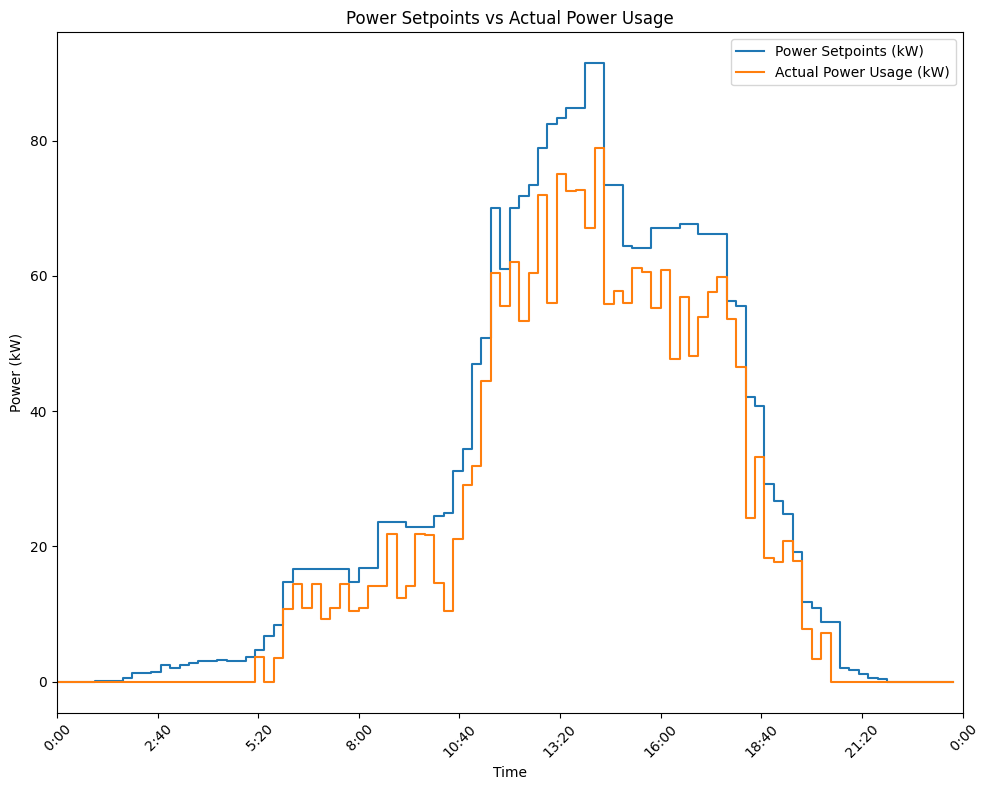

In [33]:

state, info = env.reset(seed=seed, power_setpoints=power_setpoints)


# This is the default charging algorithm that maximizes charging fairness among EVs
algorithm = RoundRobin_GF(env)

# This is an alternative charging algorithm that charges EVs as fast as possible without considering the power setpoint.
# algorithm = ChargeAsFastAsPossible(env)


# Running the simulation
done = False
while not done:
    action = algorithm.get_action(env)
    _, _, done, _, info = env.step(action)

print("\nDetailed Simulation Results:")
print("-" * 70)
print(f'Total EVs Served               : {info["total_ev_served"]:10.0f} EVs')
print(f'Total Energy Charged           : {info["total_energy_charged"]:10.2f} kWh')
print("-" * 70)
# Show costs and profits
print(f'Day-Ahead Energy Costs         : {info["charging_costs"]:10.2f} €')
print(f'Unmatched Power Costs          : {info["unmatched_power_costs"]:10.2f} €')
print(f'EV Charging Profits            : {info["cpo_profits"]:10.2f} €')
print(f'Total profits of CPO           : {info["cpo_profits"] - info["unmatched_power_costs"] - info["charging_costs"]:10.2f} €')
print("-" * 70)
# The energy user satisfaction shows how full the EV batteries were when they left the charging station
# user Satisfaction = (energy delivered) / (energy when charging as fast as possible) * 100%
print(f'Energy User Satisfaction       : {info["energy_user_satisfaction"]:10.2f}  +/- {info["std_energy_user_satisfaction"]:0.2f} %')
print(f'Min Energy User Satisfaction   : {info["min_energy_user_satisfaction"]:10.2f} %')
print("-" * 70)
# The tracking error shows how well the power setpoints were tracked
print(f'Tracking Error                 : {info["energy_tracking_error"]/4:10.2f} kWh')
print("-" * 70)

# Plotting the power setpoints and the actual power consumption    
plot_power_setpoints(env)

## CPO Business Model

The CPO’s profit comes from the difference between what they pay for energy and what EV users pay them.

First, the CPO buys energy in the day-ahead market and pays the day-ahead price.
Then, if the actual charging deviates from what was planned, they pay imbalance costs for consuming more or less energy than scheduled.
On the revenue side, they charge EV users a fixed retail price (for example 0.30 €/kWh) for every kWh delivered.

If the average cost of energy (day-ahead + imbalance) per kWh is lower than the retail price they charge EV users, the CPO makes money; if it is higher, they lose money.


## Key Challenges

The main challenge for CPOs is accurately predicting the energy demand for the following day while considering:

- **Variable EV arrival patterns**: Electric vehicles don't arrive at predictable times
- **Uncertain charging duration**: Different vehicles have different battery capacities and charging needs
- **Energy market constraints**: Day-ahead energy must be purchased before actual demand is known
- **Cost optimization**: Minimizing the difference between purchased energy and actual consumption

## Objective

The goal is to accurately **forecast the power setpoints** that **minimize** the energy buying costs.

# Quick preview of available data
Concise glance at the generated CSV outputs and how to load them into pandas.

You have to see what type of data you need to make the most accurate predictions!

In [34]:
from pathlib import Path
import pandas as pd

BASE = Path('data_generation_results')
pd.options.display.max_columns = 12  # keep previews readable
pd.options.display.width = 160

### Charging Transaction Data

This data desribes when EV charging transactions started, when they terminated, and how much energy they consumed.

In [35]:
# Charging transactions (one row per session)
sessions = pd.read_csv(BASE / 'charging_transaction_data.csv', parse_dates=['start_time', 'end_time'])
display(sessions.head())
print('\nSessions shape:', sessions.shape)

,charger_id,start_time,end_time,energy_charged(kWh)
0,59,2022-01-01 00:45:00,2022-01-01 12:45:00,33.57
1,35,2022-01-01 01:15:00,2022-01-01 12:00:00,23.13
2,69,2022-01-01 01:45:00,2022-01-01 13:15:00,6.00
3,71,2022-01-01 01:45:00,2022-01-01 11:00:00,22.39
4,85,2022-01-01 02:00:00,2022-01-01 11:15:00,13.28



Sessions shape: (43159, 4)


### Charging Prices

The electricity charging prices (Euro/kWh) for each time step.

In [36]:
# Charging prices (time index, €/kWh)
prices = pd.read_csv(BASE / 'charging_prices.csv', parse_dates=['Unnamed: 0'])
prices = prices.rename(columns={'Unnamed: 0': 'timestamp'})
prices = prices.set_index('timestamp').sort_index()
display(prices.head())
display(prices.describe())

,price
timestamp,
2022-01-01 00:00:00,-0.1247
2022-01-01 00:15:00,-0.1247
2022-01-01 00:30:00,-0.1247
2022-01-01 00:45:00,-0.1247
2022-01-01 01:00:00,-0.1340


,price
count,35040.000000
mean,-0.241910
std,0.131548
min,-0.871000
25%,-0.304943
50%,-0.216995
75%,-0.160000
max,0.222360


### Example aggregated total power

The power setpoint shows the total "forecasted" aggerated power by the CPO. 

,power_setpoint
timestamp,
2022-01-01 00:00:00,0.000000
2022-01-01 00:15:00,0.000000
2022-01-01 00:30:00,0.000000
2022-01-01 00:45:00,0.000000
2022-01-01 01:00:00,2.257468


<AxesSubplot:title={'center':'Power setpoint (kW)'}, xlabel='timestamp'>

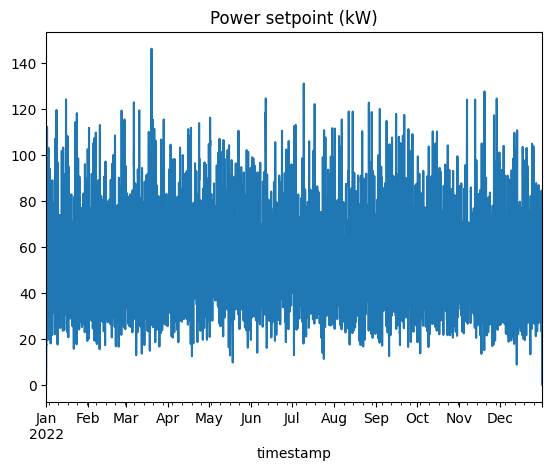

In [37]:
# Power setpoints (time index, kW)
setpoints = pd.read_csv(BASE / 'power_setpoints.csv', parse_dates=['Unnamed: 0'])
setpoints = setpoints.rename(columns={'Unnamed: 0': 'timestamp'})
setpoints = setpoints.set_index('timestamp').sort_index()
display(setpoints.head())
display(setpoints.plot(title='Power setpoint (kW)', legend=False))

### Load Profile Data per Charger
This file shows the load profiles per charger for a whole year.

In [38]:
# Charger load profiles (wide format: one row per charger, columns are 15-min timestamps)
load_profiles = pd.read_csv(BASE / 'charger_load_profiles.csv', parse_dates=['Unnamed: 0'])
load_profiles = load_profiles.rename(columns={'Unnamed: 0': 'charger_id'})
print('Load profiles shape:', load_profiles.shape)
display(load_profiles.head())

Load profiles shape: (100, 35041)


,charger_id,2022-01-01 00:00:00,2022-01-01 00:15:00,2022-01-01 00:30:00,2022-01-01 00:45:00,2022-01-01 01:00:00,...,2022-12-31 22:30:00,2022-12-31 22:45:00,2022-12-31 23:00:00,2022-12-31 23:15:00,2022-12-31 23:30:00,2022-12-31 23:45:00
0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
